# Assumptions

- Service Area denotes the functional areas (org chart) within the Borough of Barnett.
- Account Description is the name of the general ledger account in which each transaction is recorded.
- Assume that Journal Date and Transaction Date are synonymous.
- Disregard JV Date.
- Assume Total and JV Value are synonymous; these are the amount of each transaction.

# Auditor Requirements:

1.	The Auditor would like to get a summary view of the transactions for each Service Area. The summary view would include at least one visual representation of the transactions in such a way that they could compare them by quarter. Quarters are defined based on the calendar year (Q1 is January to March, Q2 April to June, etc.). The Auditor would also like a summary table with some relevant statistics (The Auditor says something along the lines of “transaction counts and averages”, but welcomes ideas).

2.	The Auditor would like to get a view if there are any significant changes in spending behavior by Service Area and by Account. Changes in behavior could be spikes, but could also be permanent increases in the transaction amounts. Please identify instances of both or show that they do not exist in the data.

3.	The Auditor would like to get an understanding of how Creditors are classified into accounts. In particular, they are worried about transaction misclassification. Are you able to identify instances in which Creditors are not consistently classified into Accounts (e.g., most of the time Creditor “AirTickets.com” is classified into “Travelling Expenses”, but on some occasions it is also found in “Miscellaneous”)? 

4.	In terms of spending behavior (defined by the number and the typical size of transactions), are there Service Areas that behave similarly and can be grouped together? How?

5.	The auditor has heard that you may know anomaly detection techniques. They would like to ask you for a sample of a few hundred transactions that are anomalous, different or worthwhile inquiring about.  The sample should include at least five transactions for each Service Area. Please provide this sample and explain why they are special or different.

# Loading External Dependencies

In [1]:
# Data Manipulation.
from pandas import read_csv, DataFrame, concat, to_datetime

# Regular-Expression.
import re

# Visualization.
from matplotlib import pyplot as plt

# Exploring Data

In [2]:
class Data:

    def __init__(self, paths : list[str]) -> None:

        # Preparing a container for storing the data.
        self.data = list()

        # Iterate over each path of data stored.
        for path in paths:

            # Add data one by one.
            self.data.append(self.load_data(path))

    def load_data(self, path : str) -> DataFrame:
        return read_csv(path)
    
    def fix_feature_names(self, new_feature_names : list[dict] = list()):
        
        # Counter for iterating over the specific dataset in the list.
        iteration = 0
        
        # Iterating over each data to change their feature name.
        for data_features in new_feature_names:
            
            # Replacing the column-names.
            self.data[iteration].rename(data_features, axis = 1, inplace = True)
            
            # Cyling through each iteration.
            iteration += 1
            
    def convert_to_datetime(self):
        
        # Iterating over each dataset.
        for data in self.data:
            
            # Iterating over each column.
            for column in data.columns:
                
                # If the column name contains a word Date in it.
                if column.__contains__('Date'):
                    
                    # Convert it to a datetime instance.
                    data[column] = to_datetime(data[column])
            
    def merge_data(self) -> DataFrame:
        return concat(self.data, ignore_index = True)
    
    # def join_data(self) -> DataFrame:
    #     return 

## Loading the Data

In [3]:
# Loading the given datasets.
pcd = Data(paths = [
    'Data/Purchasing Card Data 2014 v1.CSV',
    'Data/PCard Transactions 15-16.XSCORE',
    'Data/PCard 1617.CSV',
    'Data/1718Pcard.CSV'
])

# Displaying the data.
pcd.data

[                    Service Area             Account Description  \
 0             Childrens Services                     IT Services   
 1             Childrens Services                  Other Services   
 2             Childrens Services  Equipment and Materials Repair   
 3             Childrens Services  Equipment and Materials Repair   
 4             Childrens Services  Building Repairs & Maintenance   
 ...                          ...                             ...   
 4137      Adults and Communities                         Postage   
 4138  Children's Family Services  Equipment and Materials Purcha   
 4139  Children's Family Services  Equipment and Materials Purcha   
 4140  Children's Family Services           Books-CDs-Audio-Video   
 4141  Children's Family Services  Other Transfer Payments to Soc   
 
                  Creditor Transaction Date  JV Reference     JV Date  JV Value  
 0           123-REG.CO.UK       23/04/2014            93  20/05/2014    143.81  
 1    

In [4]:
pcd.data[0]

,Service Area,Account Description,Creditor,Transaction Date,JV Reference,JV Date,JV Value
0,Childrens Services,IT Services,123-REG.CO.UK,23/04/2014,93,20/05/2014,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,03/04/2014,111,20/05/2014,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,6,20/05/2014,309.38
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,7,20/05/2014,218.76
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,15/04/2014,381,20/05/2014,306
...,...,...,...,...,...,...,...
4137,Adults and Communities,Postage,WWW.ROYALMAIL.COM,23/02/2015,5002,16/03/2015,124
4138,Children's Family Services,Equipment and Materials Purcha,WWW.SMYTHSTOYS.COM,20/02/2015,5188,16/03/2015,89.96
4139,Children's Family Services,Equipment and Materials Purcha,WWW.TTS-GROUPS.CO.U,06/02/2015,5207,16/03/2015,445.92
4140,Children's Family Services,Books-CDs-Audio-Video,WWW.WILDGOOSE.AC,09/02/2015,5271,16/03/2015,407.44


In [5]:
pcd.data[1]

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,18/08/2015,5043.0,2
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,08/06/2015,4184.0,29.97
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,07/12/2015,6278.0,34.65
3,Children's Family Services,Equipment and Materials Purcha,99P STORES LTD,18/08/2015,5041.0,10.72
4,Children's Family Services,Subsistence,CHOPSTIX00000000000,21/05/2015,5750.0,33.7
...,...,...,...,...,...,...
3860,Children's Family Services,Food Costs,ZAHRA NEWSAGENT,17/11/2015,6042.0,3.5
3861,Children's Family Services,Food Costs,ZAHRA NEWSAGENT,20/01/2016,6751.0,4.5
3862,Children's Family Services,Food Costs,ZAHRA NEWSAGENT,21/03/2016,7535.0,4.5
3863,Children's Family Services,Food Costs,ZAHRA NEWSAGENT,31/03/2016,7639.0,4.5


In [6]:
pcd.data[2]

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total
0,Adults and Communities,Books-CDs-Audio-Video,AMAZON EU,05/12/2016,10510.0,45.00
1,Adults and Communities,Books-CDs-Audio-Video,AMAZON UK MARKETPLACE,05/12/2016,10509.0,426.57
2,Adults and Communities,Books-CDs-Audio-Video,AMAZON UK RETAIL AMAZO,06/12/2016,10524.0,121.38
3,Adults and Communities,Consumable Catering Supplies,WWW.ARGOS.CO.UK,01/03/2017,11667.0,78.94
4,Adults and Communities,CSG - IT,AMAZON UK MARKETPLACE,01/02/2017,10974.0,97.50
...,...,...,...,...,...,...
4577,Streetscene,Vehicle Running Costs,WWW.DVLA.GOV.UK,23/08/2016,9212.0,232.50
4578,Streetscene,Vehicle Running Costs,WWW.DVLA.GOV.UK,23/08/2016,9213.0,167.50
4579,Streetscene,Vehicle Running Costs,WWW.DVLA.GOV.UK,25/08/2016,9248.0,232.50
4580,Streetscene,Vehicle Running Costs,WWW.MOT-TESTING-CP,25/11/2016,10384.0,68.00


In [7]:
pcd.data[3]

,FIN.TRANSACTION DATE,FIN.POSTING DATE,FIN.TRANSACTION AMOUNT,MCH.MERCHANT NAME,MCH.CITY NAME,FIN.ORIGINAL CURRENCY AMOUNT,FIN.ORIGINAL ISO CURRENCY CODE SYMBOL,FIN.INET CONVERSION
0,06/04/17,07/04/17,36.55,TESCO STORE 2296,COLNEY HATCH,36.55,GBP,1.0
1,06/04/17,07/04/17,58.75,AMFBOWLING.CO.UK,01442 840200,58.75,GBP,1.0
2,10/04/17,11/04/17,40.50,WWW.GOJUMPIN.COM,INTERNET,40.50,GBP,1.0
3,12/04/17,13/04/17,23.90,AMFBOWLING.CO.UK,01442 840200,23.90,GBP,1.0
4,12/04/17,13/04/17,24.28,VUE BSL LTD,LONDON,24.28,GBP,1.0
...,...,...,...,...,...,...,...,...
4926,16/03/18,19/03/18,20.00,GIFFGAFF,WWW.GIFFGAFF,20.00,GBP,1.0
4927,07/03/18,08/03/18,354.25,LOVE2SHOP.CO.UK,0345 717 1111,354.25,GBP,1.0
4928,21/03/18,22/03/18,51.88,AMAZON UK MARKETPLACE,800-279-6620,51.88,GBP,1.0
4929,22/03/18,26/03/18,10.00,WWW.BRENTGOV.UK,INTERNET,10.00,GBP,1.0


- Considering the second and third dataset's last row, the record contains nothing but a sum of column-values.
- Hence, we can drop that record without any hesitation.

### Validating its features-name.

In [8]:
[d.columns for d in pcd.data]

[Index(['Service Area', 'Account Description', 'Creditor', 'Transaction Date',
        'JV Reference', 'JV Date', 'JV Value'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Journal Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Journal Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['FIN.TRANSACTION DATE', 'FIN.POSTING DATE', 'FIN.TRANSACTION AMOUNT',
        'MCH.MERCHANT NAME', 'MCH.CITY NAME', 'FIN.ORIGINAL CURRENCY AMOUNT',
        'FIN.ORIGINAL ISO CURRENCY CODE SYMBOL', 'FIN.INET CONVERSION'],
       dtype='object')]

- As we can determine that the given columns are similar but their names are different.
- So, we need to change their name and bring consistency.

### Bringing Feature-Name Consistency

In [9]:
# Changing column names.
pcd.fix_feature_names(new_feature_names = [

    # 2014:
    {
        'JV Reference' : 'Journal Reference',
        'JV Date' : 'Journal Date',
        'JV Value' : 'Journal Value'
    },
    
    # 2015-16:
    dict(),
    
    # 2016:
    dict(),
    
    # 2017-18:
    { field : re.sub(pattern = r'(.*)\.(\w+) (\w+)', repl = r'\2 \3', string = field).title() for field in pcd.data[3].columns }
])

[data.columns for data in pcd.data]

[Index(['Service Area', 'Account Description', 'Creditor', 'Transaction Date',
        'Journal Reference', 'Journal Date', 'Journal Value'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Journal Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Journal Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['Transaction Date', 'Posting Date', 'Transaction Amount',
        'Merchant Name', 'City Name', 'Original Currency Amount',
        'Original Iso Currency Code Symbol', 'Inet Conversion'],
       dtype='object')]

## Assumption:
- `Merchant Name` is `Creditor`.
- `Posting Date` is `Journal Date`.
- `Transaction Amount` is `Total` as mentioned in other datasets.
- `Merchant Name` is similar to `Account Description`, at least as per the given data.

In [10]:
# Manually fixing the feature-name missed in the first trail of complex operation.
pcd.data[3].rename({
    'Merchant Name' : 'Creditor',
    'Posting Date' : 'Journal Date',
    'Transaction Amount' : 'Total',
    'Merchant Name' : 'Account Description'
}, axis = 1, inplace = True)

pcd.data[3].columns

Index(['Transaction Date', 'Journal Date', 'Total', 'Account Description',
       'City Name', 'Original Currency Amount',
       'Original Iso Currency Code Symbol', 'Inet Conversion'],
      dtype='object')

In [11]:
pcd.convert_to_datetime()
pcd.data

C:\Users\Ratch\AppData\Local\Temp\ipykernel_22600\3367591888.py:43: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data[column] = to_datetime(data[column])
C:\Users\Ratch\AppData\Local\Temp\ipykernel_22600\3367591888.py:43: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data[column] = to_datetime(data[column])
C:\Users\Ratch\AppData\Local\Temp\ipykernel_22600\3367591888.py:43: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data[column] = to_datetime(data[column])
C:\Users\Ratch\AppData\Local\Temp\ipykernel_22600\3367591888.py:43: UserWarning: Parsing dates in

[                    Service Area             Account Description  \
 0             Childrens Services                     IT Services   
 1             Childrens Services                  Other Services   
 2             Childrens Services  Equipment and Materials Repair   
 3             Childrens Services  Equipment and Materials Repair   
 4             Childrens Services  Building Repairs & Maintenance   
 ...                          ...                             ...   
 4137      Adults and Communities                         Postage   
 4138  Children's Family Services  Equipment and Materials Purcha   
 4139  Children's Family Services  Equipment and Materials Purcha   
 4140  Children's Family Services           Books-CDs-Audio-Video   
 4141  Children's Family Services  Other Transfer Payments to Soc   
 
                  Creditor Transaction Date  Journal Reference Journal Date  \
 0           123-REG.CO.UK       2014-04-23                 93   2014-05-20   
 1      ACCE

In [12]:
pcd.data = pcd.merge_data()
pcd.data

,Service Area,Account Description,Creditor,Transaction Date,Journal Reference,Journal Date,Journal Value,Total,City Name,Original Currency Amount,Original Iso Currency Code Symbol,Inet Conversion
0,Childrens Services,IT Services,123-REG.CO.UK,2014-04-23,93.0,2014-05-20,143.81,NaN,NaN,NaN,NaN,NaN
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,2014-03-04,111.0,2014-05-20,"6,000.00",NaN,NaN,NaN,NaN,NaN
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,6.0,2014-05-20,309.38,NaN,NaN,NaN,NaN,NaN
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,7.0,2014-05-20,218.76,NaN,NaN,NaN,NaN,NaN
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,2014-04-15,381.0,2014-05-20,306,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,NaN,GIFFGAFF,NaN,2018-03-16,NaN,2018-03-19,NaN,20.00,WWW.GIFFGAFF,20.00,GBP,1.0
17516,NaN,LOVE2SHOP.CO.UK,NaN,2018-07-03,NaN,2018-08-03,NaN,354.25,0345 717 1111,354.25,GBP,1.0
17517,NaN,AMAZON UK MARKETPLACE,NaN,2018-03-21,NaN,2018-03-22,NaN,51.88,800-279-6620,51.88,GBP,1.0
17518,NaN,WWW.BRENTGOV.UK,NaN,2018-03-22,NaN,2018-03-26,NaN,10.00,INTERNET,10.00,GBP,1.0


## Data Statistics

In [13]:
pcd.data.describe()

,Journal Reference,Inet Conversion
count,12587.000000,4931.000000
mean,6126.846906,1.002227
std,3248.967457,0.025384
min,1.000000,1.000000
25%,3943.500000,1.000000
50%,5795.000000,1.000000
75%,8847.500000,1.000000
max,12136.000000,1.380000


# Data Preprocessing

In [14]:
# Converting the dates in Pandas DateTime instance.
pcd.data['Transaction Date'] = to_datetime(pcd.data['Transaction Date'], format = '%Y/%m/%d', errors = 'coerce')
pcd.data['Journal Date'] = to_datetime(pcd.data['Journal Date'], format = '%Y/%m/%d', errors = 'coerce')
pcd.data

,Service Area,Account Description,Creditor,Transaction Date,Journal Reference,Journal Date,Journal Value,Total,City Name,Original Currency Amount,Original Iso Currency Code Symbol,Inet Conversion
0,Childrens Services,IT Services,123-REG.CO.UK,2014-04-23,93.0,2014-05-20,143.81,NaN,NaN,NaN,NaN,NaN
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,2014-03-04,111.0,2014-05-20,"6,000.00",NaN,NaN,NaN,NaN,NaN
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,6.0,2014-05-20,309.38,NaN,NaN,NaN,NaN,NaN
3,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,2014-02-04,7.0,2014-05-20,218.76,NaN,NaN,NaN,NaN,NaN
4,Childrens Services,Building Repairs & Maintenance,ALLSOP & FRANCIS,2014-04-15,381.0,2014-05-20,306,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,NaN,GIFFGAFF,NaN,2018-03-16,NaN,2018-03-19,NaN,20.00,WWW.GIFFGAFF,20.00,GBP,1.0
17516,NaN,LOVE2SHOP.CO.UK,NaN,2018-07-03,NaN,2018-08-03,NaN,354.25,0345 717 1111,354.25,GBP,1.0
17517,NaN,AMAZON UK MARKETPLACE,NaN,2018-03-21,NaN,2018-03-22,NaN,51.88,800-279-6620,51.88,GBP,1.0
17518,NaN,WWW.BRENTGOV.UK,NaN,2018-03-22,NaN,2018-03-26,NaN,10.00,INTERNET,10.00,GBP,1.0


In [15]:
# Quarter of Transaction Date.
pcd.data['quarter'] = pcd.data['Transaction Date'].dt.to_period('Q').dropna()
pcd.data.quarter

0        2014Q2
1        2014Q1
2        2014Q1
3        2014Q1
4        2014Q2
          ...  
17515    2018Q1
17516    2018Q3
17517    2018Q1
17518    2018Q1
17519    2018Q1
Name: quarter, Length: 17520, dtype: period[Q-DEC]

# Data Visualization

## 1. Summary of Transaction Date with Service Area.

In [16]:
# Grouping Service Area for each Quarter based on Transaction Date.
transactions = pcd.data.groupby(['Service Area', 'quarter']).agg(
    transaction_count = ('Transaction Date', 'count')
).reset_index()

transactions

,Service Area,quarter,transaction_count
0,Adults and Communities,2014Q1,2
1,Adults and Communities,2014Q2,15
2,Adults and Communities,2014Q3,11
3,Adults and Communities,2014Q4,14
4,Adults and Communities,2015Q1,5
...,...,...,...
98,Streetscene,2014Q4,21
99,Streetscene,2015Q1,26
100,Streetscene,2015Q2,1
101,Streetscene,2015Q3,4


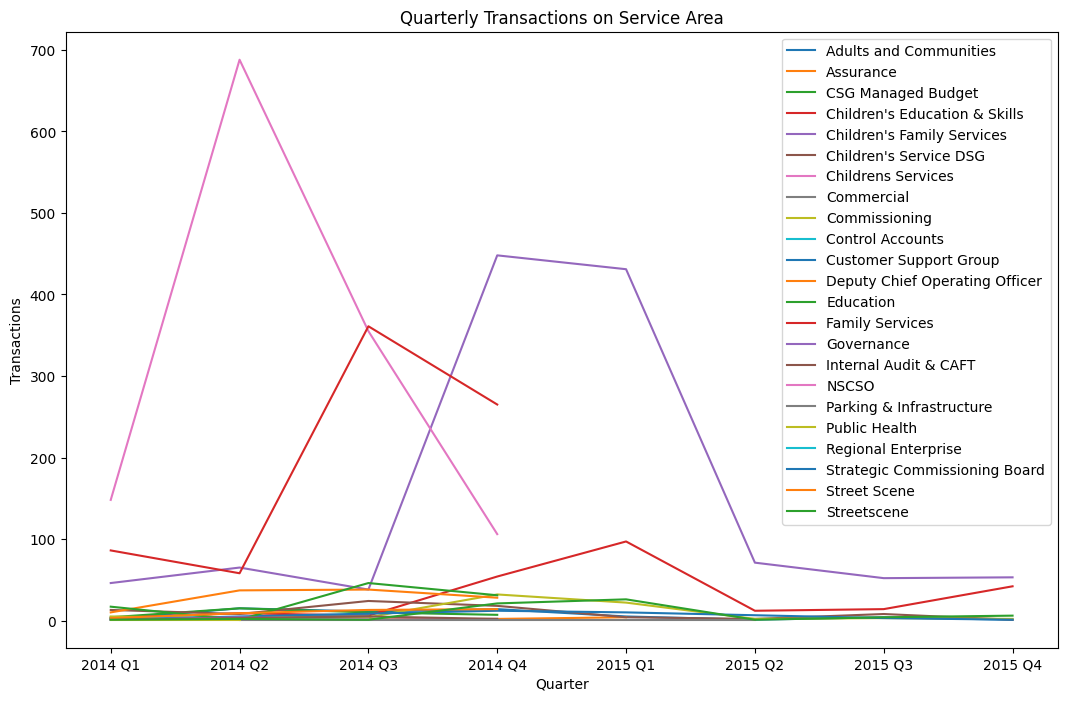

In [17]:
# Chart Resolution: 1280 x 800p
plt.figure(figsize = (12.8, 8))

# Creating a visualization.
for areas in transactions['Service Area'].unique():
    areas_data = transactions[transactions['Service Area'] == areas]
    quarters = [areas_data.quarter]
    plt.plot([quarter.strftime('%Y Q%q') for quarter in areas_data.quarter], areas_data.transaction_count, label = areas)
    
# Chart Decoration.
plt.legend()

plt.xlabel('Quarter')
plt.ylabel('Transactions')

plt.title('Quarterly Transactions on Service Area')

# Display the Chart.
plt.show()

### Trendy Bar Chart

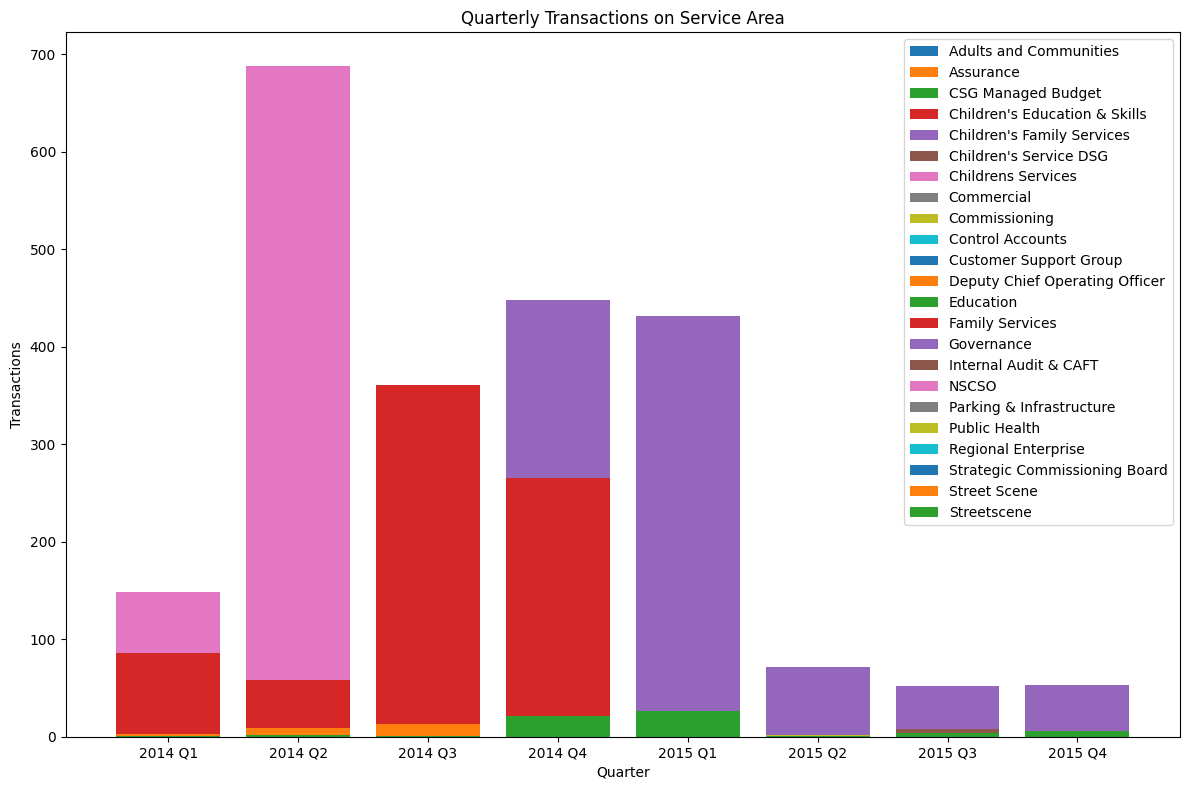

In [18]:
# Chart Resolution: 1280 x 800p
plt.figure(figsize = (12, 8))

# Create the Visualization.
for areas in transactions['Service Area'].unique():
    areas_data = transactions[transactions['Service Area'] == areas]
    plt.bar([quarter.strftime('%Y Q%q') for quarter in areas_data.quarter], areas_data.transaction_count, label = areas)
    
# Chart Decoration.
plt.legend()

plt.xlabel('Quarter')
plt.ylabel('Transactions')

plt.title('Quarterly Transactions on Service Area')

plt.tight_layout()

plt.show()

## 2. Behavior of Spendings.

In [27]:
pcd.data['amount_change_percentage'] = pcd.data.groupby(['Service Area', 'Account Description'])['Journal Value'].pct_change()
pcd.data.amount_change_percentage
huge_changes = pcd.data[(pcd.data.amount_change_percentage > 0.5) | (pcd.amount_change_percentage < -0.5)]
huge_changes

TypeError: unsupported operand type(s) for /: 'str' and 'str'

## 3. Classification of Creditors into Accounts.

In [32]:
# Grouping creditors with accounts.
creditors_count = pcd.data.groupby(['Creditor', 'Account Description']).size().reset_index(name = 'Count')
creditors_count

,Creditor,Account Description,Count
0,ARGOS,Other Transfer Payments to Soc,1
1,COFFEE REPUBLIC WOO,Food Costs,1
2,COSTCUTTER,Food Costs,1
3,H HARIA CHEMIST,Other Transfer Payments to Soc,1
4,LEWISS,Equipment and Materials Purcha,1
...,...,...,...
2870,ZAHRA NEWSAGENT,Books-CDs-Audio-Video,1
2871,ZAHRA NEWSAGENT,Food Costs,13
2872,ZIZZI CENTRAL ST,Training,1
2873,amazonpayments.co.u,Private Contractors - Third Pa,2


In [34]:
# Identifying `Creditors` being classified into various `Account Description`.
creditors_classifications = creditors_count[creditors_count.duplicated(subset = 'Creditor', keep = False)]
creditors_classifications

,Creditor,Account Description,Count
15,123-REG.CO.UK,IT Services,1
16,123-REG.CO.UK,Subscriptions,1
22,99P STORES LTD,E19 - Learning Resources,1
23,99P STORES LTD,Equipment and Materials Purcha,2
25,A&Y LOCKSMITHS,Clothing - Protective Clothing,1
...,...,...,...
2859,WWW.YELLOWMOON.ORG.UK,Other Services,1
2861,WWW.ZATPAY.COM,IT Services,1
2862,WWW.ZATPAY.COM,Other Services,2
2870,ZAHRA NEWSAGENT,Books-CDs-Audio-Video,1
